In [1]:
import sqlalchemy
import pandas as pd
pd.set_option('display.max_rows', None)

url_object = sqlalchemy.engine.URL.create(
    "postgresql+psycopg2",
    username="pguser",
    password="pgpass",
    host="localhost",
    database="finance_dwh",
    port=5431
)

engine = sqlalchemy.create_engine(
    url_object)


query_str = """select description, count(*) cnt
from public.company_facts group by description order by cnt desc limit 100

"""

pd.read_sql_query(query_str, con=engine)

,description,cnt
0,NetIncomeLoss,834975
1,StockholdersEquity,630416
2,CashAndCashEquivalentsAtCarryingValue,628947
3,OperatingIncomeLoss,592199
4,EarningsPerShareBasic,589275
5,EarningsPerShareDiluted,574189
6,IncomeTaxExpenseBenefit,547564
7,WeightedAverageNumberOfSharesOutstandingBasic,497181
8,WeightedAverageNumberOfDilutedSharesOutstanding,478433
9,Assets,452648


In [2]:
from statsmodels.regression.rolling import RollingOLS
import numpy as np
from scipy.stats import linregress
from datetime import date

query_str = """select 
 "end", 
  val,
  ticker
from public.company_facts 
where description = 'ProfitLoss' and fy > 2020 and val != 0 and frame is not null and length(frame) != 6
order by ticker, "end" asc limit 50000

"""

df = pd.read_sql_query(query_str, con=engine)

df['rolling_slope'] = (df.groupby('ticker')['val']
   .rolling(window=4)
   .apply(lambda v: linregress(np.arange(len(v)), v).slope )
   .reset_index(level=0, drop=True)
)

df = df.loc[df['end'] >= date(2022,12,31)]

df = df.sort_values(['rolling_slope'], ascending=[False])
df[:100]


,end,val,ticker,rolling_slope
11702,2022-12-31,91049000000,IX,2.510200e+09
9180,2022-12-31,2238000000,GE,1.036700e+09
7228,2022-12-31,2326000000,EMR,4.570000e+08
13727,2022-12-31,1120000000,MCK,3.401000e+08
6164,2023-01-29,1957000000,DE,2.947000e+08
6325,2022-12-31,1361000000,DIS,1.532000e+08
8590,2022-12-31,321000000,FOX,1.505000e+08
8601,2022-12-31,321000000,FOXA,1.505000e+08
6337,2022-12-31,954469000,DISH,1.406447e+08
4389,2022-12-31,-266722000,CGC,1.401967e+08


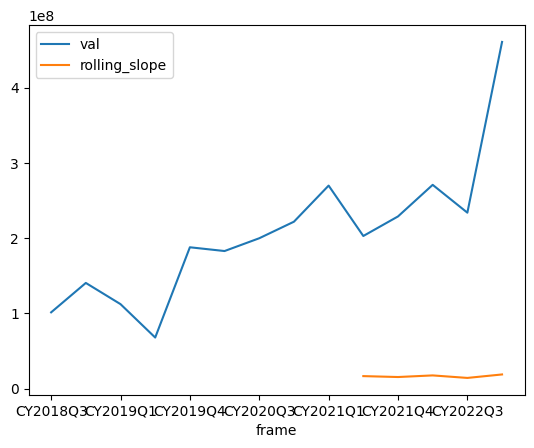

In [3]:

import matplotlib.pyplot as plt
query_str = """select 
 "end", 
  val,
  ticker,
  description,
  form,
  filed,
  frame
from public.company_facts 
where val != 0 and ticker = 'AMCR' and description = 'ProfitLoss' and frame is not null and length(frame) != 6
order by frame, val desc limit 50000


"""


df = pd.read_sql_query(query_str, con=engine)
df['rolling_slope'] = (df.groupby('ticker')['val']
   .rolling(window=10)
   .apply(lambda v: linregress(np.arange(len(v)), v).slope )
   .reset_index(level=0, drop=True)
)
df.plot(x='frame')

plt.show()